# Check Electron populations
Use the implemented functions

In [1]:
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from astropy.wcs import WCS
from ClusterModel import model
from ClusterModel import model_modpar
from ClusterModel import model_tools

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
clust = model.Cluster(name='Coma', 
                      redshift=0.023, M500=7e14*u.Msun, 
                      cosmology=cosmo, silent=False, 
                      output_dir='/home/astrogamma/Project/Output/TestClusterModel')

                 __  __ ___ ___   _   ___   ___                 
                |  \/  |_ _/ __| /_\ |   \ / _ \                
                | |\/| || | (__ / _ \| |) | (_) |               
                |_|  |_|___\___/_/ \_\___/ \___/                
 Modeling the Intra Cluster Atmosphere for Diverse Observations 
----------------------------------------------------------------
                                                                
Setting gNFW Planck coll. (2013) UPP.


## Check Density and Spectrum

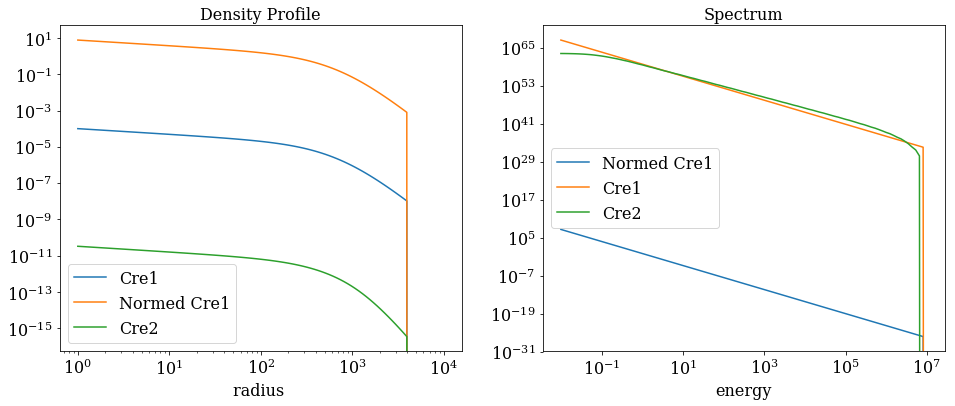

In [3]:
radius=np.logspace(0,4,100)*u.kpc
energy=np.logspace(-2,7,100)*u.GeV

# The simplest plots: density profile and spectrum
plt.figure(figsize=(15,6))
plt.subplot(121)

a,b = clust.get_density_cre1_profile(radius)
plt.loglog(a,b, label='Cre1')
a, b = clust.get_normed_density_cre1_profile(radius)
plt.loglog(a, b, label='Normed Cre1')
a,b = clust.get_density_cre2_profile(radius)
plt.loglog(a,b, label='Cre2')
plt.xlabel('radius ')
plt.title("Density Profile")
plt.legend()


plt.subplot(122)
a, b = clust.get_normed_cre1_spectrum(energy)
plt.loglog(a, b,label = 'Normed Cre1')
a, b = clust.get_cre1_spectrum(energy)
plt.loglog(a,b, label = 'Cre1')
a, b = clust.get_cre2_spectrum(energy)
plt.loglog(a,b, label = 'Cre2')
plt.xlabel('energy')
plt.title("Spectrum")
plt.legend()

## Check Synchrotron

Text(0.5,1,'Rate Total')

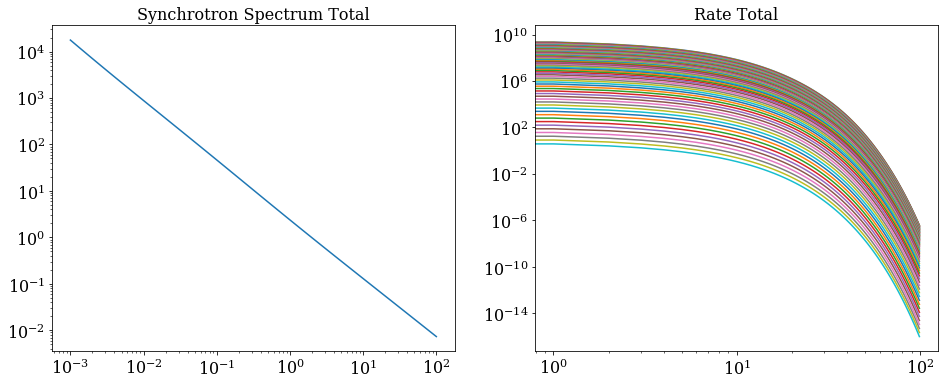

In [4]:

plt.figure(figsize = (15,6))
plt.subplot(121)
### Automatic function
frequency, readyspectrum = clust.get_synchrotron_spectrum()
plt.loglog(frequency,readyspectrum)
plt.title("Synchrotron Spectrum Total")

#New one 
plt.subplot(122)
total_rate = clust.get_rate_synchrotron()
plt.loglog(total_rate)
plt.title("Rate Total")


# Fit to Coma Data

In [5]:

dat_freq = np.array([30.9,43,73.8,151,326,408,430,608.5,1380,1400,2675,2700,4850])*u.MHz
dat_flux = np.array([49,51,17,7.2,3.81,2.0,2.55,1.2,0.53,0.64,0.11,0.07,0.03])*u.Jy
dat_err  = np.array([10,13,12,0.8,0.03,0.2,0.28,0.3,0.05,0.035,0.03,0.02,0.01])*u.Jy

from scipy import optimize

dat_freq = dat_freq.to('GHz')

In [6]:
%%time



def syncfitSecondary(x,a, ind):
    clust.X_crp_E = {'X':a, 'R_norm': clust.R500}
    clust.X_cre1_E = {'X':0, 'R_norm': clust.R500}
    clust.spectrum_crp_model = {'name':'PowerLaw', 'Index':ind }
    return clust.get_synchrotron_spectrum(x*u.GHz)[1].to_value('Jy')

params2, params_covariance = optimize.curve_fit(syncfitSecondary, dat_freq.to_value('GHz'), dat_flux.to_value('Jy'), 
                                               sigma = dat_err.to_value('Jy'),
                                               p0=[0.01, 3])


print "Secondary electron parameters: ",(params2)


Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Getting R500 value
Setting cosmic ray to thermal pressure ratio v

In [9]:
%%time

def syncfitPrimary(x,a, ind):
    clust.X_crp_E = {'X':0, 'R_norm': clust.R500}
    clust.X_cre1_E = {'X':a, 'R_norm': clust.R500}
    clust.spectrum_crp_model = {'name':'PowerLaw', 'Index':ind }
    return clust.get_synchrotron_spectrum(x*u.GHz)[1].to_value('Jy')


params1, params_covariance = optimize.curve_fit(syncfitPrimary, dat_freq.to_value('GHz'), dat_flux.to_value('Jy'), 
                                               sigma = dat_err.to_value('Jy'),
                                               p0=[0.01, 3])

print "Primary Electron Parameters: ", (params1)

Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Getting R500 value
Setting cosmic ray to thermal pressure ratio v

/home/astrogamma/.local/anaconda3/envs/cta/lib/python2.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## Plot Them all

Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Setting spectrum_crp_model value


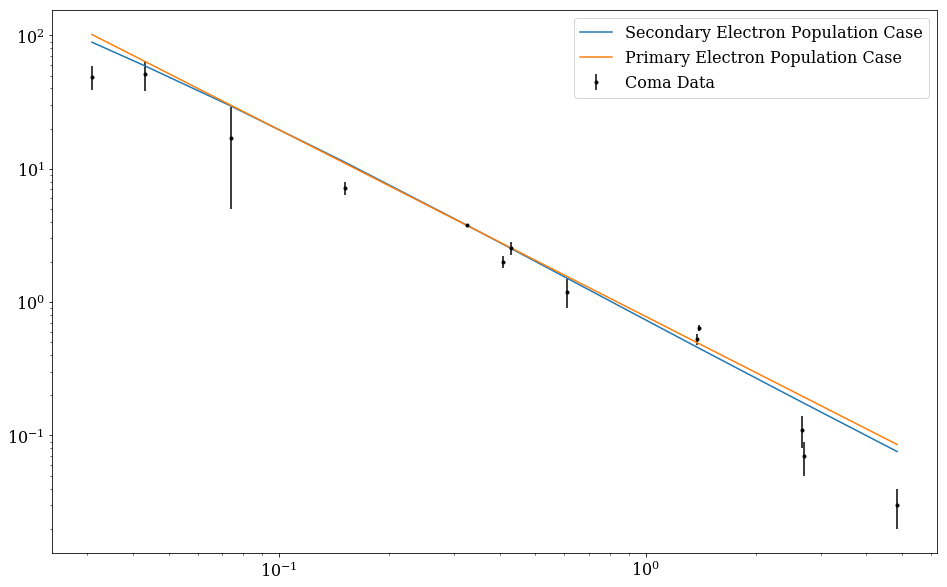

In [11]:
plt.figure(figsize=(15, 10))

## Plot Data
plt.errorbar(dat_freq.to_value('GHz'), dat_flux.to_value('Jy'), yerr = dat_err.to_value('Jy') , 
             fmt="k.", label = "Coma Data")
## Plot Secondary Electron version
plt.loglog(dat_freq, syncfitSecondary(dat_freq.to_value('GHz'), params2[0],params2[1]),
         label='Secondary Electron Population Case')
## Plot Primary Electron version
plt.loglog(dat_freq, syncfitPrimary(dat_freq.to_value('GHz'), params1[0],params1[1]),
         label='Primary Electron Population Case')

plt.legend(loc='best')

